# initializing modules and loading data from dataset

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('coffee_sales.csv')
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


# feature engineering

In [61]:
df['date'] = pd.to_datetime(df['date'])                 #date column to date in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])         #datetime column to datetime in datetime format

#extract time features
df['hour'] = df['datetime'].dt.hour                     #extract hour from datetime, 0-23 for each hour of the day
df['day_of_week'] = df['date'].dt.dayofweek             #extract the day of the week from date, mon-sun:0-6
df['month'] = df['date'].dt.month                       #extract month from date, jan-dec:1-12

#transform categorical features
le_coffee = LabelEncoder()
le_cash = LabelEncoder()
df['coffee_type'] = le_coffee.fit_transform(df['coffee_name'])  #encode coffee type
df['cash_type'] = le_cash.fit_transform(df['cash_type'])        #encode cash type

#generate aggregated daily data for prediction
daily_data = df.groupby('date').agg({
    'money': 'sum',                                     #total revenue per day
    'coffee_type': ['count', lambda x: x.mode()[0]],    #total orders per day    
    'hour': ['mean', 'max'],                            #avg hr or the mean of time of transaction and peak hr per day
    'day_of_week': 'first',                             #day of the week for each date
    'month': 'first',                                   #month for each date
    'cash_type': 'mean'                                 #card to cash use ratio per day where 1 is card and 0 is cash
}).reset_index()

#setting column names
daily_data.columns = ['date', 
                     'daily_revenue', 
                     'daily_orders',
                     'most_popular_coffee', 
                     'avg_hour', 
                     'peak_hour', 
                     'day_of_week', 
                     'month', 
                     'card_usage_ratio'
                ]
print("average daily revenue: ", daily_data['daily_revenue'].mean())
#display
daily_data.head()

average daily revenue:  302.9700262467191


,date,daily_revenue,daily_orders,most_popular_coffee,avg_hour,peak_hour,day_of_week,month,card_usage_ratio
0,2024-03-01,396.3,11,1,15.090909,19,4,3,0.000000
1,2024-03-02,228.1,7,0,12.571429,17,5,3,0.142857
2,2024-03-03,349.1,10,1,14.400000,18,6,3,0.100000
3,2024-03-04,135.2,4,7,11.250000,14,0,3,0.000000
4,2024-03-05,338.5,9,6,15.888889,18,1,3,0.000000


# exploratory data analysis

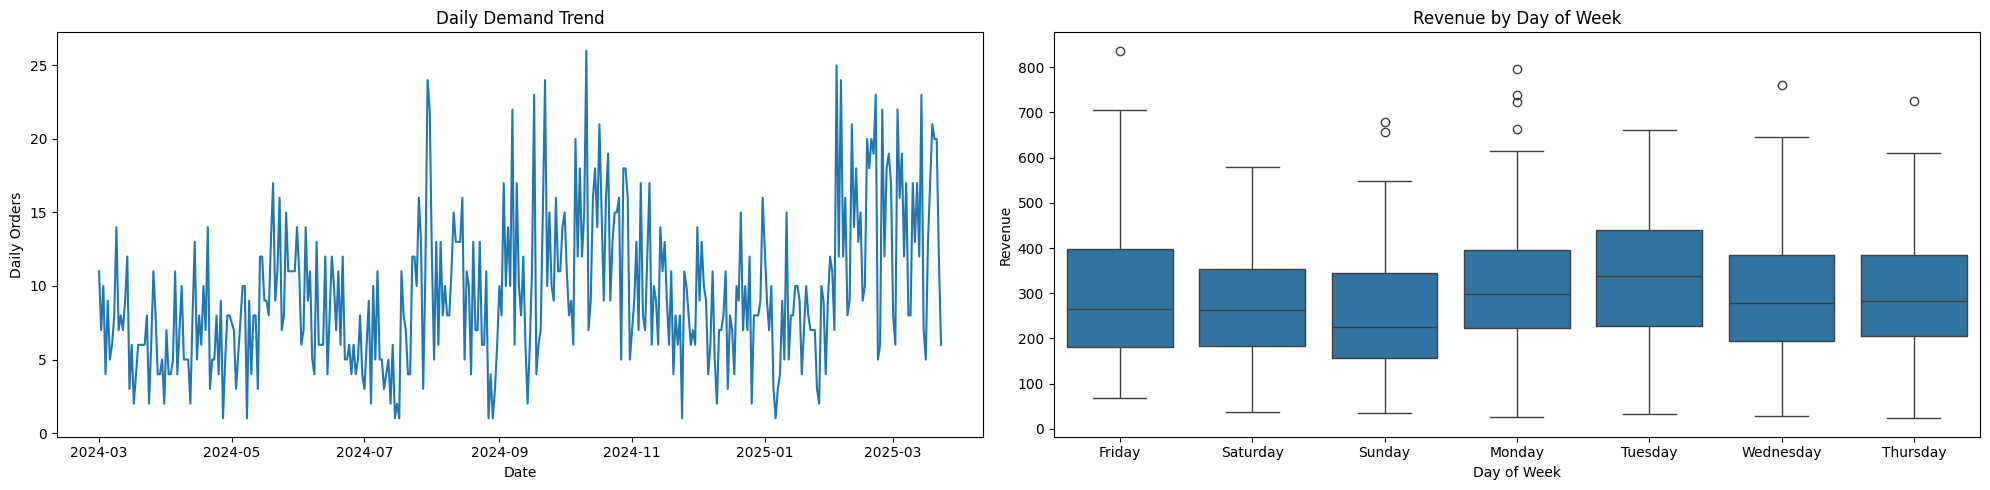

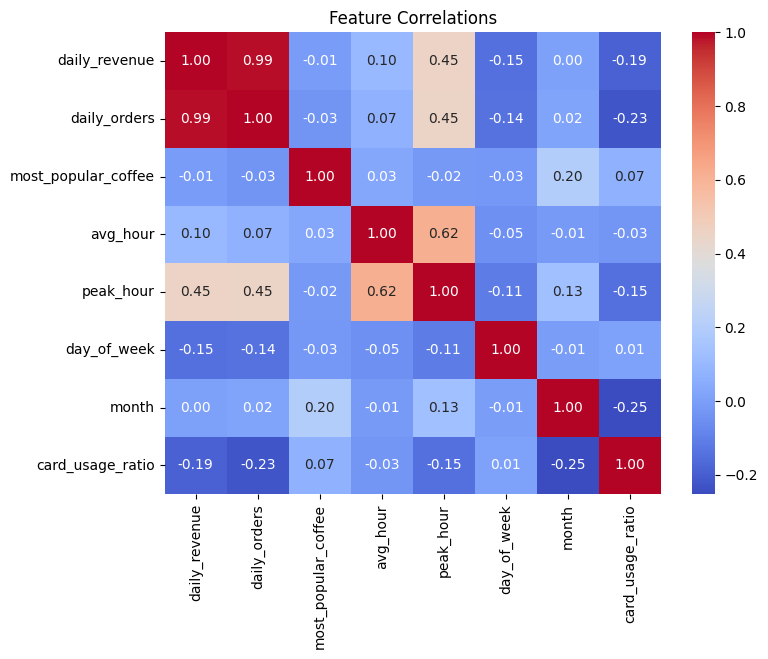

In [62]:
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_data['weekday_name'] = daily_data['day_of_week'].map(dict(zip(range(7), day_labels)))

                        #set the size of the plot wxh   
plt.figure(figsize=(20, 5))  
#plot date against volume of orders
plt.subplot(1, 2, 1)                                    #allocates a 1x2 grid for the separate plots, sets this plot to first index
sns.lineplot(                                           #create a line plot
            data=daily_data,                            #set which data to use
            x='date',                                   #set x axis for date
            y='daily_orders')                           #set y axis for daily orders
plt.xlabel('Date')                                       #set x axis label
plt.ylabel('Daily Orders')                               #set y axis label 
plt.tight_layout()                                      #ensure no overlaps, etc. in the plot created
plt.title('Daily Demand Trend')                         #titles the plot

#plot revenue by day of the week
plt.subplot(1, 2, 2)                                    #set this plot to the second index in the subplot
sns.boxplot(                                            #create a box plot
            data=daily_data,                            
            x='weekday_name', 
            y='daily_revenue')
plt.title('Revenue by Day of Week')
plt.xlabel('Day of Week')                                 #set x axis label
plt.ylabel('Revenue')                                     #set y axis label
plt.tight_layout()                                      #ensure no overlaps, etc. in the plot created                                         #display the plot
plt.show()    


#plot correlation between values
plt.figure(figsize=(8, 6))
sns.heatmap(
    daily_data.corr(numeric_only=True),                 #essentially compute numeric correlation between values present in daily_data
    annot=True,                                         #display correl values in each cell
    cmap='coolwarm',                                    #set the color map cool (negative) -> warm (positive)
    fmt=".2f")                                          #set the displayed values to 2 decimal places
plt.title('Feature Correlations')
plt.show()


# data cleaning

In [63]:
Q1 = daily_data['daily_revenue'].quantile(0.25)
Q3 = daily_data['daily_revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_data['daily_revenue'] = daily_data['daily_revenue'].clip(lower_bound, upper_bound)

# model training

In [64]:
X = daily_data.drop(['date', 'most_popular_coffee', 'weekday_name', 'daily_orders'],axis=1)  #drop the date, daily revenue, most popular coffee, weekday name and daily orders columns
y_demand = daily_data['daily_orders']
y_revenue = daily_data['daily_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y_demand, test_size=0.3, random_state=42)

# Train models
demand_model = RandomForestRegressor(
    n_estimators=700,
    max_depth=10,
    min_samples_leaf=3,
    max_features=0.5, 
    random_state=42,
    n_jobs=-1) 
demand_model.fit(X_train, y_train)


,n_estimators,700
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# evaluation

DEMAND (Daily Orders) Metrics:
R²: 0.963
MAE: 0.7096412727069279


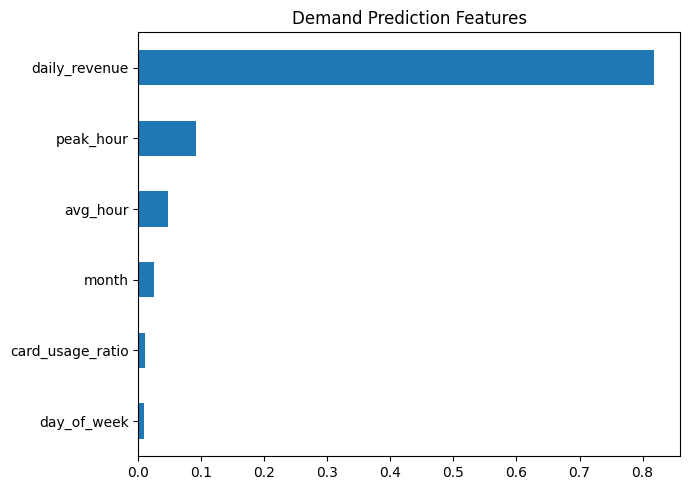

In [65]:
#predict demand
demand_pred = demand_model.predict(X_test)

#print metrics
def print_metrics(y_true, y_pred, label):
    print(f"{label} Metrics:")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE:", mean_absolute_error(y_test, demand_pred))

print_metrics(y_test, demand_pred, "DEMAND (Daily Orders)")

# Feature Importance
fig, ax = plt.subplots(figsize=(7, 5))
pd.Series(demand_model.feature_importances_, index=X.columns).sort_values().plot.barh()
plt.title('Demand Prediction Features')
plt.tight_layout()
plt.show()


In [66]:
sample_day = pd.DataFrame({
    'avg_hour': [10],
    'peak_hour': [11],
    'day_of_week': [4], 
    'month': [12],
    'card_usage_ratio': [0.7],
    'daily_revenue': [250]
})[X.columns]

print(f"Predicted Daily Orders: {demand_model.predict(sample_day)[0]:.0f}")

Predicted Daily Orders: 7
